<a href="https://colab.research.google.com/github/susant146/PyTorch_Basics_CNNmodels/blob/main/ImageDenoising_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
# Image Denoising using UNet.

import os
from collections import OrderedDict

import torch
import torch.nn as nn
from torchsummary import summary
import os
import cv2  # for image reading and processing
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from matplotlib import pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**UNet Model**

`[1]` Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18 (pp. 234-241). Springer International Publishing.

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels = 1, out_channels = 1, init_features = 32):
        super(UNet, self).__init__()

        # Encoder (Down Stream)
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1") #_block: perfoems 2 Conv Operations
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features*2, name='enc2')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features*2, features*4, name='enc3')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features*4, features*8, name='enc4')
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features*8, features*16, name='bottleneck')

        # Decoder (Un Stream)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features*2)*2, features*2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block((features)*2, features, name="dec1")


        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    # Define the forward-propagation.
    def forward(self, x):
        # bs, c, w, h
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.InstanceNorm2d(num_features=features)), # InstanceNorm
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.InstanceNorm2d(num_features=features)), # Instance
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

**Parameter Summary**

In [ ]:
# Check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if __name__ == "__main__":
    image = torch.rand((1,1,256,256))
    image = image.to(device)       # Load tensor to "device"
    model = UNet().to(device)
    print(model(image).shape)

print(device)
summary(model, input_size=(1, 256, 256), batch_size=1, device=str(device))

torch.Size([1, 1, 256, 256])
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 256, 256]             288
    InstanceNorm2d-2          [1, 32, 256, 256]               0
              ReLU-3          [1, 32, 256, 256]               0
            Conv2d-4          [1, 32, 256, 256]           9,216
    InstanceNorm2d-5          [1, 32, 256, 256]               0
              ReLU-6          [1, 32, 256, 256]               0
         MaxPool2d-7          [1, 32, 128, 128]               0
            Conv2d-8          [1, 64, 128, 128]          18,432
    InstanceNorm2d-9          [1, 64, 128, 128]               0
             ReLU-10          [1, 64, 128, 128]               0
           Conv2d-11          [1, 64, 128, 128]          36,864
   InstanceNorm2d-12          [1, 64, 128, 128]               0
             ReLU-13          [1, 64, 128, 128]               0
      

**Gaussian Noise For Data-preparation**

In [ ]:
# Function to add Gaussian noise to the image
# Note: image should be between [0,1] & std = [0,1]
# noisy_image clipped between [0,1]
def add_gaussian_noise(image, std):
    noise = np.random.normal(0, std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

**Denoising Datader - Custom Dataset**

In [ ]:
class DenoiseDataset(Dataset):
    def __init__(self, image_dir, noise_std_range, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.noise_std_range = noise_std_range
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = image.astype(np.float32)
        image_resized = cv2.resize(image, (256, 256))

        # Add Gaussian noise
        std = np.random.uniform(self.noise_std_range[0], self.noise_std_range[1])
        std = std/255.0     # std normalized to image dynamic range
        # Normalize the image
        image_resized /= 255.0
        noisy_image = add_gaussian_noise(image_resized, std)


        if self.transform:
            image_resized = self.transform(image_resized)
            noisy_image = self.transform(noisy_image)

        return image_resized, noisy_image  # return noisy and clean image pair

**Create DataLoader**

In [ ]:
# Hyperparameters
batch_size = 32
noise_std_range = (20, 20)  # Gaussian noise std range

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
])

# Create Dataset and DataLoader
dataset = DenoiseDataset(image_dir='/content/drive/MyDrive/images',
                         noise_std_range=noise_std_range,
                         transform=transform)

**Train, Test and Validation Data**

In [ ]:
# dataset contains all the image data and the corresponding noisy image
# We will divide the image data in 80% Training, 10% Test and 10% Validation data.
dataset_size = len(dataset)
print('Total image data in the dataset: ', dataset_size)
train_size = int(0.80 * dataset_size)  # 80% for training
val_size = int(0.10 * dataset_size)    # 10% for validation
test_size = dataset_size - train_size - val_size  # 10% for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Total image data in the dataset:  3443


In [ ]:
# Now create Train_dataset, test_dataset and val_dataset from these data.
# We will see how to send these data into devices also.

# Number of workers for data loading (set based on your system)
num_workers = 2  # Adjust based on your system

# Create DataLoaders with num_workers and pin_memory optimization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

**Combined Loss Function**



In [ ]:
# Initialize loss functions
mse_loss = torch.nn.MSELoss()  # Mean Squared Error (MSE) Loss
l1_loss = torch.nn.L1Loss()    # L1 Loss (Mean Absolute Error)

# SSIM Loss (Custom implementation)
# def ssim_loss(output, target,  win_size=7):
#     # Detach the tensors from the computation graph before converting to NumPy
#     output_np = output.squeeze().cpu().detach().numpy()
#     target_np = target.squeeze().cpu().detach().numpy()

#     # Compute SSIM loss
#     loss = 1 - ssim(output_np, target_np, data_range=1.0, win_size=win_size, multichannel=False)

#     # Convert the loss to a tensor and move it to the same device as the output
#     return torch.tensor(loss).to(output.device)

# Combined Loss Function (MSE + L1 + SSIM)
def combined_loss(output, target, alpha=0.2):#, beta=0.3):
    mse = mse_loss(output, target)
    l1 = l1_loss(output, target)
    # ssim_l = ssim_loss(output, target, win_size=7)  # Assuming you have an SSIM loss function
    return alpha * mse + (1-alpha) * l1 #+ (1 - alpha - beta) * ssim_l

**Training Epochs**

In [ ]:
# Initialize the model, optimizer, and scheduler
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

# Training loop with validation loss monitoring
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for noisy_images, clean_images in train_loader:
        noisy_images, clean_images = noisy_images.to(device).float(), clean_images.to(device).float()
        clean_images = clean_images
        # print(clean_images.shape)
        noisy_images = noisy_images
        optimizer.zero_grad()

        # Forward pass
        denoised_images = model(noisy_images)
        # Compute the loss
        loss = combined_loss(denoised_images, clean_images)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_images, clean_images in val_loader:
            noisy_images, clean_images = noisy_images.to(device).float(), clean_images.to(device).float()

            # Forward pass
            denoised_images = model(noisy_images)
            loss = combined_loss(denoised_images, clean_images)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/2], Train Loss: 0.1957, Val Loss: 0.1892
Epoch [2/2], Train Loss: 0.1623, Val Loss: 0.1555


**Save Model Parameters**

In [ ]:
# After the training loop, save the model
torch.save(model.state_dict(), './unet_denoise_model.pth')
print("Model saved successfully!")

Model saved successfully!


**Load Model & Inference**

<ipython-input-20-52638a84047b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/unet_denoise_model.pth'))


Model loaded successfully!
PSNR: Noisy =  24.651823953671364
PSNR: Denoised =  22.223738459578716


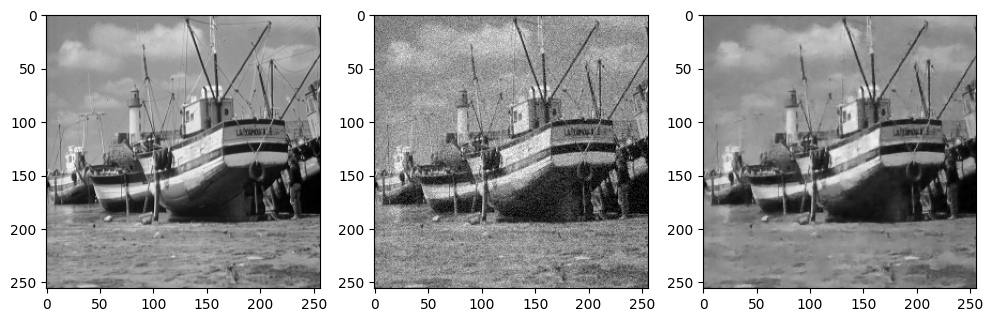

In [ ]:
model = UNet()
model.load_state_dict(torch.load('/content/unet_denoise_model.pth'))
model.eval()  # Set model to evaluation mode

print("Model loaded successfully!")

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))  # Convert image to tensor
])

# Function for inference (denoising)
def denoise_image(model, noisy_image):
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        # Transform the image (convert to tensor and add batch dimension)
        noisy_image_tensor = transform(noisy_image).unsqueeze(0).float()  # Ensure it's float32

        # Forward pass through the model
        denoised_image = model(noisy_image_tensor)

        # Convert back to NumPy
        denoised_image = denoised_image.squeeze(0).cpu().numpy()  # Remove batch dimension
        # denoised_image = denoised_image * 0.5 + 0.5
    return denoised_image

# Load an example image and add noise
image_path = '/content/drive/MyDrive/boat.png'
clean_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
clean_image = cv2.resize(clean_image, (256, 256))
clean_image = clean_image.astype(np.float32) / 255.0  # Normalize to [0, 1]

# Add Gaussian noise for inference
noise_std = 20 / 255.0  # Example noise level
noisy_image = add_gaussian_noise(clean_image, noise_std)
psnrN = psnr(clean_image, noisy_image, data_range=1.0)
print('PSNR: Noisy = ', psnrN)

# Denoise the image using the trained model
denoised_image = denoise_image(model, noisy_image)
denoised_image = denoised_image.squeeze(0)
psnrD = psnr(clean_image, denoised_image, data_range=1.0)
print('PSNR: Denoised = ', psnrD)

# Display the denoised image
plt.figure(figsize=[12, 12])
plt.subplot(1,3,1)
plt.imshow(clean_image, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(noisy_image, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(denoised_image, cmap='gray')
plt.show()